In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm

from math import log2
from random import choices
from scipy.sparse import dok_matrix, csr_matrix, dok_array, hstack, vstack
from scipy.spatial.distance import cosine, euclidean
from scipy.sparse.linalg import svds, inv

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import TruncatedSVD, PCA

from tensorflow.keras.layers import Input, Dot, Embedding, Dense, Flatten, Lambda, Concatenate, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

# GloVe Embedding

In [36]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [37]:
M = len(all_words)
M

100649

In [38]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## Computation of the co-ocurrence matrix

In [6]:
def count_word_coocurrence(docs, vocab, wsize=10):
    term_term_dict = {}
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    M = len(vocab)
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [7]:
word_cooc_matrix = count_word_coocurrence(docs, all_words, wsize=5)

## Creating GloVe neural network estimator

In [8]:
def get_training_sets(cooc: dok_matrix):
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [9]:
X, y = get_training_sets(word_cooc_matrix)

In [10]:
X.shape

(6134986, 2)

In [11]:
EMB_SIZE=50

In [12]:
target = Input(shape=1, name="context_input")
context = Input(shape=1, name="target_input")

embed_layer = Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot_layer = Dot(axes=2)( [ embed_target, embed_context ] )
flat = Flatten()(dot_layer)

model = Model(inputs=[ target, context ], outputs=flat)

In [13]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )

In [14]:
model.compile(optimizer="adam", loss=loss)

In [20]:
model.fit([ X[:,0], X[:,1] ], y, epochs=10, batch_size=64)

In [16]:
embed_vectors = model.get_weights()[0]

In [17]:
u = PCA().fit_transform(embed_vectors)

In [74]:
np.argsort([
    euclidean( 
        embed_vectors[word2int("cnn")],
        embed_vectors[i]
    ) for i in range(embed_vectors.shape[0])
])[:15]

array([  992,   489,   488,    68,   450, 31480, 25362, 56725,  1063,
       36925,  1292, 56726, 41913, 60365,  2767], dtype=int64)

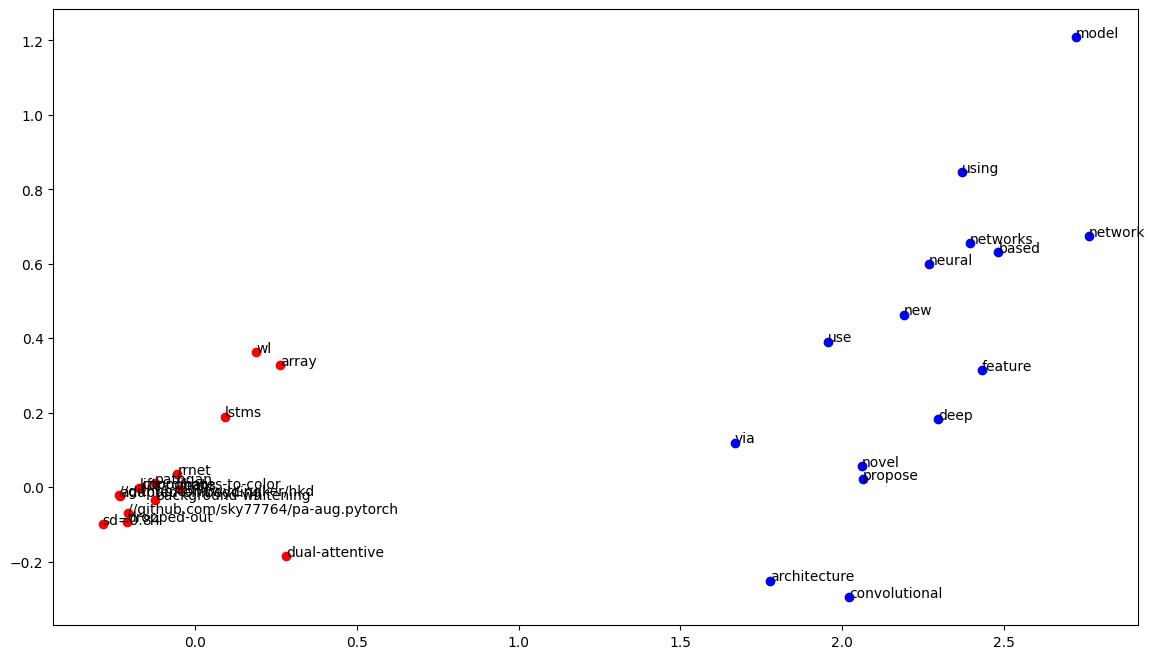

In [92]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("network")], 
        u[i]
    ) for i in range(len(u))
])[:15]

random = np.random.choice(list(range(len(u))), size=15, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

In [87]:
model.save("gloVe.h5")

# Word2Vec Embedding

In [2]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [3]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## CBOW

In [4]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            context_set = tuple(sorted(context_set))
            
            dataset[context_set] = dataset.get(context_set, set()) | {current_word}
    return dataset

In [5]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

In [6]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

### Full dataset


#### 1. Testing CBOW with the default mode (predicting correct class)

In [7]:
M = len(all_words)

In [9]:
wsize=4

In [10]:
ds = get_dataset(docs, wsize)

In [11]:
X,y = unwind(ds)

In [12]:
EMB_SIZE=50

In [ ]:
model = Sequential([
    Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    Dense(units=M, activation="softmax", name="activation_layer")
])
    

In [48]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [ ]:
model.fit(x=X, y=y, batch_size=128, epochs=1)

In [23]:
model.save("cbow.h5")

In [27]:
embed_vectors = model.get_weights()[0]

In [28]:
pca = PCA().fit_transform(embed_vectors)

In [57]:
np.argsort([ 
    euclidean(
        pca[word2int("bridge")], 
        pca[i]
    ) for i in range(len(pca))
])[:15]

array([   11, 12934, 31193,  2919, 28473, 32610, 83848, 74653, 89796,
        7153, 56906, 37408, 50647, 62902, 56907], dtype=int64)

In [ ]:
int2word(32610)

In [66]:
list(all_words.keys())[1200:1225]

['endowed',
 'boundary',
 'artifacts',
 'refining',
 'contours',
 'generation',
 'final',
 'codes',
 '//github.com/liqiokkk/fctl',
 '-dimensional',
 'whereby',
 'clustered',
 'edge',
 'general',
 'probabilistic',
 'mathematical',
 'devised',
 'thresholds',
 'calculated',
 'indicate',
 'randomly-generated',
 'points',
 'projected',
 'structures',
 'partition']

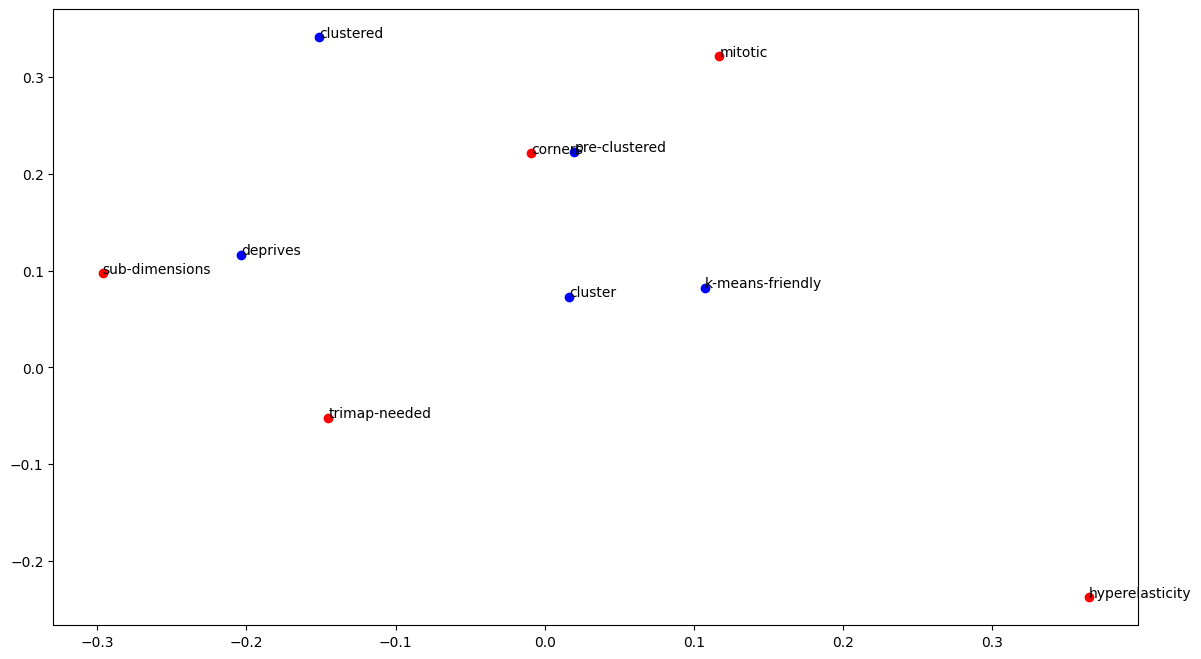

In [67]:
k=5
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("cluster")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))

#### 2. CBOW with negative sampling

In [6]:
wsize=4

In [7]:
ds = get_dataset(docs, wsize)

In [8]:
context_words, target_words = unwind(ds)

In [9]:
context_words.shape

(1949427, 8)

In [10]:
k=5
M = len(all_words)
EMB_DIM = 50

In [11]:
context = Input(shape=wsize*2)
target = Input(shape=1)
n_targets = Input(shape=k)

embedding_layer = Embedding(M, EMB_DIM, name="emb_layer")
mean_layer = Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=(EMB_DIM))
reshape_layer = Reshape((1, EMB_DIM))
dot_layer = Dot(axes=2)
concat = Concatenate()

cemb = embedding_layer(context)
cemb = mean_layer(cemb)
cemb = reshape_layer(cemb)

temb = embedding_layer(target)
nemb = embedding_layer(n_targets)

out = dot_layer([cemb, temb])
n_out = dot_layer([-cemb, nemb])

out = concat([out, n_out])

model = Model(inputs=[context, target, n_targets], outputs=out)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 emb_layer (Embedding)          multiple             5032450     ['input_1[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 50)           0           ['emb_layer[0][0]']              
                                                                                              

In [13]:
vocab = list(all_words.values())

In [18]:
def epochs_generator(context_words, target_words, n_nsamples, batch_size=1, epochs=1):
    idx = np.arange(context_words.shape[0], dtype=int)
    np.random.shuffle(idx)
    context_words = context_words[idx]
    target_words = target_words[idx]    
    
    i = 0
    while i < int(context_words.shape[0]):
        c = context_words[i:i+batch_size]
        t = target_words[i:i+batch_size]
        
        new_shape = len(c)
        
        n_targets = np.array(
            choices(vocab, k=n_nsamples*new_shape)
        ).reshape(n_nsamples, new_shape)
        
        c = c.reshape(new_shape,-1)
        t = t.reshape(new_shape,-1)
        n = n_targets.reshape(new_shape,-1)

        out = np.array([[1] + [0]*n_nsamples]*new_shape).reshape(new_shape,-1)
        yield ([c, t, n], out)
        i+=batch_size

In [27]:
@tf.function
def cbow_loss(y_test, preds):
    return -tf.reduce_sum(
        tf.math.log_sigmoid(preds)
    )

In [28]:
model.compile("adam", cbow_loss)

In [ ]:
batch_size=32
model.fit(
    epochs_generator(context_words, target_words, k, batch_size), 
    steps_per_epoch=np.ceil(len(context_words)/batch_size)
)

11523/60920 [====>.........................] - ETA: 10:27 - loss: 246198.7031

In [89]:
model.save("models/cbow_negative_sampling.h5")

In [22]:
embed_vectors = model.get_weights()[0]

In [23]:
pca = PCA().fit_transform(embed_vectors)

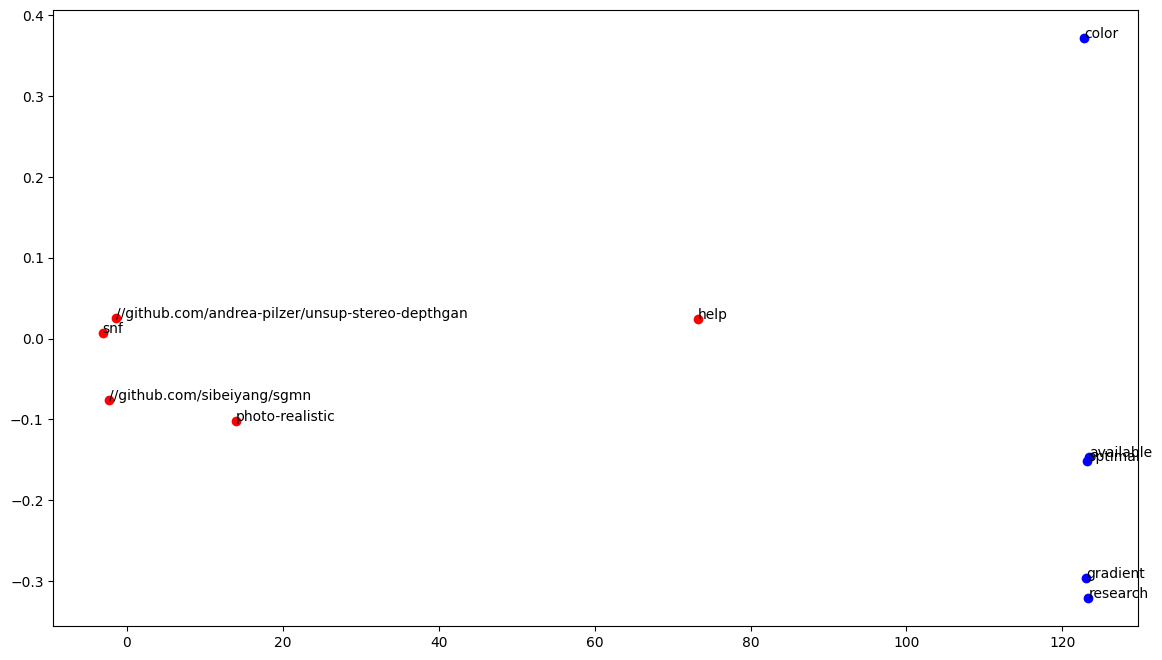

In [26]:
k=5
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("research")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))